In [70]:
import numpy as np

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from scipy import stats

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
torch.manual_seed(1)

import time
from datetime import datetime

from collections import defaultdict
from collections import Counter

from random import randint
import pickle

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('error')

import string
puncs = set(string.punctuation)

In [71]:
#training sets
with open('tokenized_lower.en') as f:
    train_en = [l.strip() for l in f.readlines()]
with open('tokenized_lower.fr') as f:
    train_fr = [l.strip() for l in f.readlines()]

# #validation sets
# with open('val.en') as f:
#     val_en = [l.strip() for l in f.readlines()]
# with open('val.fr') as f:
#     val_fr = [l.strip() for l in f.readlines()]

# #test sets
# with open('test_2017_flickr.en') as f:
#     test_en = [l.strip() for l in f.readlines()]
# with open('test_2017_flickr.fr') as f:
#     test_fr = [l.strip() for l in f.readlines()]

In [72]:
#TODO
# 0 PAD - padding 0 for convenience in masking?
# 1 BOS - beginning of sentence
# 2 EOS - end of sentence
# 3 UNK - unknown

In [73]:
max_sentence_length = 50

In [74]:
def tokens_sentences(sentences):
    tokens_list = []
    sentence_list = []
    for s in sentences:
        split_sent = s.split()
        sentence = []
        for w in split_sent:

            if w not in puncs:
                tokens_list.append(w)
                sentence.append(w)

        sentence_list.append(sentence)
    
    return tokens_list, sentence_list

In [75]:
tokens_list_en, sentence_list_en = tokens_sentences(train_en)

tokens_train_en = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
tokens_train_en.extend(list(sorted(set(tokens_list_en))))
vocab_size_en = len(tokens_train_en)
print('Vocabulary size EN', vocab_size_en)

count_tokens_train_en = Counter(tokens_list_en)

tokens_list_fr, sentence_list_fr = tokens_sentences(train_fr)

tokens_train_fr = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
tokens_train_fr.extend(list(sorted(set(tokens_list_fr))))
vocab_size_fr = len(tokens_train_fr)
print('Vocabulary size FR', len(tokens_train_fr))

count_tokens_train_fr = Counter(tokens_list_fr)

Vocabulary size EN 10203
Vocabulary size FR 11215


In [76]:
def get_id_dicts(tokens):
    #default dictionary key:id value:token
    id2tokens = defaultdict(str)

    for i in range(len(tokens)):
        id2tokens[i] = tokens[i]

    #default dictionary key:token value:id
    tokens2id = defaultdict(int)

    for ind in id2tokens:
        tokens2id[id2tokens[ind]] = ind

    return tokens2id, id2tokens

In [77]:
tokens2id_en, id2tokens_en = get_id_dicts(tokens_train_en)

vocabulary_size_train_en = len(tokens2id_en)
print(vocabulary_size_train_en)

tokens2id_fr, id2tokens_fr = get_id_dicts(tokens_train_fr)

vocabulary_size_train_fr = len(tokens2id_fr)
print(vocabulary_size_train_fr)

10203
11215


In [78]:
def convert_corpus2id(sentence_list, tokens2id, max_sentence_length):
    
    #convert dataset to ids
    corpus2id = []
    
    for s in sentence_list:
    
        sentence2id = []
        sentence2id.append(tokens2id['<SOS>'])
    
        for w in s:
            word_id = tokens2id[w]
            sentence2id.append(word_id)
        
        
        sentence2id.append(tokens2id['<EOS>'])
        
        if len(sentence2id) < max_sentence_length:
            corpus2id.append(sentence2id)
    
    return corpus2id

In [79]:
corpus2id_en = convert_corpus2id(sentence_list_en, tokens2id_en, max_sentence_length)
corpus2id_fr = convert_corpus2id(sentence_list_fr, tokens2id_fr, max_sentence_length)

In [80]:
corpus2id_en[0]

[1, 9496, 10178, 9971, 5319, 420, 6111, 5822, 5353, 1321, 2]

In [173]:
class Encoder(nn.Module):
    def __init__(self,vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length):
        super(Encoder, self).__init__()
        
        self.vocab_size_fr = vocab_size_fr
        self.max_sentence_length = max_sentence_length
        self.w_embedding_dim = w_embedding_dim
        self.p_embedding_dim = p_embedding_dim
        
        self.dec_embedding_dim = dec_embedding_dim
        
        #encoder
        self.w_embeddings = nn.Embedding(self.vocab_size_fr, self.w_embedding_dim)
        self.p_embeddings = nn.Embedding(self.max_sentence_length, self.p_embedding_dim)
        
        self.context_emb_dim = self.w_embedding_dim + self.p_embedding_dim
        
        self.average_projection = nn.Linear(self.context_emb_dim, self.dec_embedding_dim)
        
        self.attention_projection = nn.Linear(self.context_emb_dim, self.dec_embedding_dim)
        #do we use non-linearity after attention
        
        #TODO: DROPOUT
        
        
    def forward(self, sent_fr, pos_fr):
        
        #embedded = self.embedding(input).view(1, 1, -1)
        #TODO:BATCH
        
        ws = []
        ps = []
        es = []
        
        for s in range(len(sent_fr)):
            word = sent_fr[s]
            pos = pos_fr[s]
            
            w_out = self.w_embeddings(word)

            p_out = self.p_embeddings(pos)

            e_out = torch.cat((w_out, p_out), 0)
    
            ws.append(w_out)
            ps.append(p_out)
            es.append(e_out)
        
        stacked_contexts = torch.stack(es, dim = 0)
        average_context = torch.mean(stacked_contexts, dim = 0)
        average_context = self.average_projection(average_context)
        
        stacked_contexts = self.attention_projection(stacked_contexts)
            
        return average_context, stacked_contexts

class Decoder(nn.Module):
    def __init__(self, dec_embedding_dim, vocab_size_en, max_sentence_length, dropout_prob):
        super(Decoder, self).__init__()
        
        self.vocab_size_en = vocab_size_en
        self.max_sentence_length = max_sentence_length
        
        self.dec_embedding_dim = dec_embedding_dim
        
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(self.dropout_prob)
        
        self.embedding = nn.Embedding(self.vocab_size_en, self.dec_embedding_dim)
        
        self.rnn = nn.RNN(self.dec_embedding_dim, self.dec_embedding_dim)
        #self.bidirLSTM = nn.LSTM(self.embedding_dim, self.embedding_dim, bidirectional=True)
        #TODO: LSTM, GRU 
       
        self.pre_rnn_affine = nn.Linear(self.dec_embedding_dim*2, self.dec_embedding_dim)
        #a linear layer after this before softmax
        self.out_affine = nn.Linear(self.dec_embedding_dim, self.vocab_size_en)
               
    
    def forward(self, gold_target_sent, encoder_avg_context, encoder_stacked_contexts, train):
        
        pred = []
        attentions = []
        
        if train: #if training time
            for s in range(len(gold_target_sent)):
                gold_word = gold_target_sent[s]

                output = self.embedding(gold_word)

                output = self.dropout(output)

                if s == 0:

                    weighted_context = torch.zeros(output.shape)
                    output = torch.cat((output, weighted_context), 0)

                    output = F.relu(self.pre_rnn_affine(output))
                    #TODO: start with 0 vector as h0

                    output, hidden = self.rnn(output.view(1, 1, -1), encoder_avg_context.view(1, 1, -1))
                    prev_hidden = hidden

                    s_output = self.out_affine(output[0])
                    s_output = F.log_softmax(s_output, dim=1) #TODO: CHECK DIM AND OUTPUT[0]

                    pred.append(s_output)

                elif s == len(gold_target_sent)-1:

                    #end of sentence
                    break

                else:

                    #start with weighted context
                    output = torch.cat((output, weighted_context), 0)

                    output = F.relu(self.pre_rnn_affine(output))

                    output, hidden = self.rnn(output.view(1, 1, -1), prev_hidden.view(1, 1, -1))
                    prev_hidden = hidden

                    s_output = self.out_affine(output[0])

                    s_output = F.log_softmax(s_output, dim=1) #TODO: CHECK DIM AND OUTPUT[0]
                    pred.append(s_output)

                attention_weights_word = F.log_softmax(torch.matmul(encoder_stacked_contexts, prev_hidden.view(-1,1)), dim = 0)

                #print(attention_weights_word)

                weighted_context = torch.sum(torch.mul(attention_weights_word, encoder_stacked_contexts), dim = 0)

                attentions.append(attention_weights_word)


            attention_weights = torch.stack(attentions, dim=0)

            pred = torch.stack(pred, dim=0)
            
            return pred, attention_weights
        
        else: #if testing time
            
            decoder_outputs = []
            decoder_attentions = []
        
            test_word = torch.tensor(np.asarray([tokens2id_en['<SOS>']]), dtype = torch.long)
            
            test_word_id = tokens2id_en['<SOS>']
            
            for w in range(self.max_sentence_length):
       
                if test_word_id == tokens2id_en['<EOS>']:
                    
                    break  
                    
                output = self.embedding(test_word)
            
                if w == 0:
                    
                    weighted_context = torch.zeros(output.shape)
                    output = torch.cat((output.squeeze(), weighted_context.squeeze()), 0)
                    
                    output = F.relu(self.pre_rnn_affine(output))
                    #TODO: start with 0 vector as h0

                    output, hidden = self.rnn(output.view(1, 1, -1), encoder_avg_context.view(1, 1, -1))
                    prev_hidden = hidden

                    s_output = self.out_affine(output[0])
                    s_output = F.log_softmax(s_output, dim=1) 

                    test_word_id = int(torch.argmax(s_output))
                    test_word = torch.tensor(np.asarray([test_word_id]), dtype = torch.long)
           
                    
                else:   
                    #start with weighted context
                    
                    output = torch.cat((output.squeeze(), weighted_context.squeeze()), 0)

                    output = F.relu(self.pre_rnn_affine(output))

                    output, hidden = self.rnn(output.view(1, 1, -1), prev_hidden.view(1, 1, -1))
                    prev_hidden = hidden

                    s_output = self.out_affine(output[0])

                    s_output = F.log_softmax(s_output, dim=1)
                    
                    test_word_id = int(torch.argmax(s_output))
                    
                    test_word = torch.tensor(np.asarray([test_word_id]), dtype = torch.long)
                    
                
                attention_weights_word = F.log_softmax(torch.matmul(encoder_stacked_contexts, prev_hidden.view(-1,1)), dim = 0)

                weighted_context = torch.sum(torch.mul(attention_weights_word, encoder_stacked_contexts), dim = 0)

                attentions.append(attention_weights_word)
                
                decoder_outputs.append(test_word_id)
                
                                  

            attention_weights = torch.stack(attentions, dim=0)            
            
            return decoder_outputs, attention_weights

    
    #https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    

epoch, total loss, duration
0 90.75369071960449 0:00:00.605966
1 87.48334503173828 0:00:00.578439
2 84.11409664154053 0:00:00.580589
3 81.71895456314087 0:00:00.586815
4 78.93817663192749 0:00:00.594281
5 76.55218505859375 0:00:00.588490
6 74.29257726669312 0:00:00.577081
7 72.24408054351807 0:00:00.597675
8 70.41592597961426 0:00:00.590078
9 68.8714952468872 0:00:00.655750


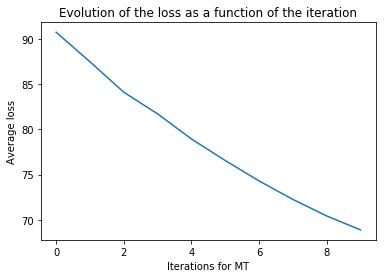

['<SOS>', 'deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '<EOS>']
['<SOS>', 'two', 'young', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '<EOS>']
['a', '<EOS>']


In [174]:
epochs = 10
learning_rate = 0.01
w_embedding_dim = 100
p_embedding_dim = 100
dec_embedding_dim = 100
dropout_prob = 0.1

model_encoder = Encoder(vocab_size_fr, w_embedding_dim, p_embedding_dim, dec_embedding_dim, max_sentence_length)
model_decoder = Decoder(dec_embedding_dim, vocab_size_en, max_sentence_length, dropout_prob)

optimizer_encoder = optim.SGD(model_encoder.parameters(), lr = learning_rate)
optimizer_decoder = optim.SGD(model_decoder.parameters(), lr = learning_rate)

loss_func = nn.NLLLoss()
losses = []
avg_losses = []

portion = 10

train = True
print('epoch, total loss, duration')
for e in range(epochs):
    
    then = datetime.now()
    
    total_loss = 0.0
    for s in range(portion):
     
        current_input = corpus2id_fr[s]
        gold_output = corpus2id_en[s]
        
        if len(current_input) > 0 and len(gold_output) > 0:
            
            optimizer_encoder.zero_grad()
            optimizer_decoder.zero_grad()
            
            sent_fr = torch.tensor(np.asarray(current_input), dtype= torch.long)
            sent_en = torch.tensor(np.asarray(gold_output), dtype= torch.long)

            pos_fr = torch.tensor(np.asarray([p for p in range(len(sent_fr))]))
            pos_en = torch.tensor(np.asarray([p for p in range(len(sent_en))]))

            average_context, stacked_contexts = model_encoder(sent_fr, pos_fr)
        
            pred, attention_weights = model_decoder(sent_en, average_context, stacked_contexts, train)
            
            #print(pred, sent_en)
            sent_en = sent_en[1:len(sent_en)] #skip SOS
            loss = loss_func(pred.squeeze(), sent_en)
        
            loss.backward()

            optimizer_encoder.step()
            optimizer_decoder.step()

            total_loss += loss.item() 
        
    
    now = datetime.now()
        
    losses.append(total_loss)
    
    print(e, total_loss, now-then)
    

with open('model_encoder' + str(portion) + '.pickle','wb') as file:
    pickle.dump(model_encoder,file)
      

with open('model_decoder' + str(portion) + '.pickle','wb') as file:
    pickle.dump(model_decoder,file)
    
iteration= list(range(len(losses)))

plt.plot(iteration, losses)
plt.xlabel("Iterations for MT")
plt.ylabel('Average loss')
plt.title('Evolution of the loss as a function of the iteration')
plt.savefig("mt" + str(portion)+".png")
plt.show()

test_fr_sentence = corpus2id_fr[0]
test_en_sentence = corpus2id_en[0]
    
decoder_outputs, decoder_attentions = evaluate_test(model_encoder, model_decoder,test_fr_sentence, test_en_sentence)

print(word_ids2string(test_fr_sentence, id2tokens_fr))
print(word_ids2string(test_en_sentence, id2tokens_en))
print(word_ids2string(decoder_outputs, id2tokens_en))

In [168]:
pair = 10

test_fr_sentence = corpus2id_fr[pair]
test_en_sentence = corpus2id_en[pair]
    
decoder_outputs, decoder_attentions = evaluate_test(model_encoder, model_decoder,test_fr_sentence, test_en_sentence)

print(word_ids2string(test_fr_sentence, id2tokens_fr))
print(word_ids2string(test_en_sentence, id2tokens_en))
print(word_ids2string(decoder_outputs, id2tokens_en))

['<SOS>', 'une', 'classe', 'de', 'ballet', 'composée', 'de', 'cinq', 'filles', 'sautent', 'en', 'cadence', '<EOS>']
['<SOS>', 'a', 'ballet', 'class', 'of', 'five', 'girls', 'jumping', 'in', 'sequence', '<EOS>']
['a', '<EOS>']


In [14]:
with open('model_encoder' + str(portion) + '.pickle','rb') as file:
    model_encoder = pickle.load(file)
      

with open('model_decoder' + str(portion) + '.pickle','rb') as file:
    model_decoder = pickle.load(file)

In [153]:
def evaluate_test(model_encoder, model_decoder, sent_fr, sent_en):
    
    with torch.no_grad():
        
        sent_fr = torch.tensor(np.asarray(sent_fr), dtype= torch.long)
        sent_en = torch.tensor(np.asarray(sent_en), dtype= torch.long)

        pos_fr = torch.tensor(np.asarray([p for p in range(len(sent_fr))]))
        pos_en = torch.tensor(np.asarray([p for p in range(len(sent_en))]))

        average_context, stacked_contexts = model_encoder(sent_fr, pos_fr)
        
        decoder_outputs, decoder_attentions = model_decoder(sent_en, average_context, stacked_contexts, train=False)
    
    return decoder_outputs, decoder_attentions

In [16]:
def word_ids2string(sentence, id2token):
    
    converted = []

    for s in sentence:
        converted.append(id2token[s])
        
    return converted

In [17]:
#TODO
#BEAM SEARCH
#teacher forcing prob
#dropout prob
#gru lstm rnn check
#relu before rnn?

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def visualize_attention(model, sentence):
    
    #model_encoder, model_decoder, sent_en, sent_fr
    
#************************************************************************
# A is the attention torch Tensor: the output of your model
# S is the softmax version of S, also a torch Tensor! (actually more acurately it's a Variable(Tensor(..))
#************************************************************************

    # Plot the attention tensor
    plt.clf()
    numpy_S = S.data.numpy() # get the data in Variable, and then the torch Tensor as numpy array
    plt.imshow(numpy_S)
    plt.savefig("attention-sent-{}-epoch-{}".format(i, step))

In [135]:
a = torch.tensor(np.asarray([i for i in range(10)]), dtype= torch.float)

In [286]:
a

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [140]:
asf = F.log_softmax(a, dim=0)
print(asf)

tensor([-9.4586, -8.4586, -7.4586, -6.4586, -5.4586, -4.4586, -3.4586,
        -2.4586, -1.4586, -0.4586])


In [287]:
a*0.1

tensor([ 0.0000,  0.1000,  0.2000,  0.3000,  0.4000,  0.5000,  0.6000,
         0.7000,  0.8000,  0.9000])

In [161]:
b = torch.tensor(np.asarray([i+1 for i in range(10)]), dtype= torch.float)

In [318]:
st = torch.stack([a,b], dim = 0)
print(st)

tensor([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
        [  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]])


In [343]:
weights = torch.tensor(np.asarray([0.1, 0.2]), dtype = torch.float).view(-1,1)
print(weights.shape)

torch.mul(weights, st)
# torch.matmul(weights.view(1,2), st)

torch.Size([2, 1])


tensor([[ 0.0000,  0.1000,  0.2000,  0.3000,  0.4000,  0.5000,  0.6000,
          0.7000,  0.8000,  0.9000],
        [ 0.2000,  0.4000,  0.6000,  0.8000,  1.0000,  1.2000,  1.4000,
          1.6000,  1.8000,  2.0000]])

In [163]:
torch.stack([a,b], dim = 1)

tensor([[  0.,   1.],
        [  1.,   2.],
        [  2.,   3.],
        [  3.,   4.],
        [  4.,   5.],
        [  5.,   6.],
        [  6.,   7.],
        [  7.,   8.],
        [  8.,   9.],
        [  9.,  10.]])

In [164]:
torch.mean(st, dim = 1)

tensor([ 4.5000,  5.5000])

In [166]:
torch.mean(st, dim = 0)

tensor([ 0.5000,  1.5000,  2.5000,  3.5000,  4.5000,  5.5000,  6.5000,
         7.5000,  8.5000,  9.5000])

In [176]:
F.softmax(st, dim = 0)

tensor([[ 0.2689,  0.2689,  0.2689,  0.2689,  0.2689,  0.2689,  0.2689,
          0.2689,  0.2689,  0.2689],
        [ 0.7311,  0.7311,  0.7311,  0.7311,  0.7311,  0.7311,  0.7311,
          0.7311,  0.7311,  0.7311]])

In [390]:
a = a*-1

In [405]:
long(torch.argmax(a))

NameError: name 'long' is not defined

In [469]:
test_word = torch.tensor(np.asarray([tokens2id_en['<SOS>']]), dtype = torch.long)
print(test_word, test_word.shape)

tensor([ 1]) torch.Size([1])


In [ ]:

#     attn_weights = F.softmax(
#             self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
#         attn_applied = torch.bmm(attn_weights.unsqueeze(0),
#                                  encoder_outputs.unsqueeze(0))

#         output = torch.cat((embedded[0], attn_applied[0]), 1)
#         output = self.attn_combine(output).unsqueeze(0)
           
#         atts= torch.matmul(es, hidden_from_decoder)
        
#         weighted_context = es*attention_weights
        
        #if EOS for encoder, move on to the decoder
        
        #attention_matrices = self.attention_projection(e_out)
        
        #input embedding
        #set hidden at the beginning
        #get rnn output
        #apply softmax

        #feed actual word for training
        #feed previous word for testing

#             #view_shape = embeddings.shape[0]
#             output, (hidden, cell) = self.bidirLSTM(embeddings.view(1, 1, -1)) 

#             hid_f = hidden[0]
#             hid_b = hidden[1]